In [1]:
import os
from utils.dataset import IOSMapDataset, make_transform

crocodl_dataset = "/media/emmanuel/nvme_storage/datasets/crocodl_dataset"

root_ios = os.path.join(crocodl_dataset, 'HYDRO', 'sessions')
tfm = make_transform()
map_ds = IOSMapDataset(root_ios, transform=tfm, subsession="ios_2023-10-27_10.20.23_000")

In [2]:
import numpy as np
from PIL import Image


data = [map_ds[i] for i in range(50, 61)]
paths = [data_item['path'] for data_item in data]

images = [
    np.array(Image.open(path))
    for path in paths
]

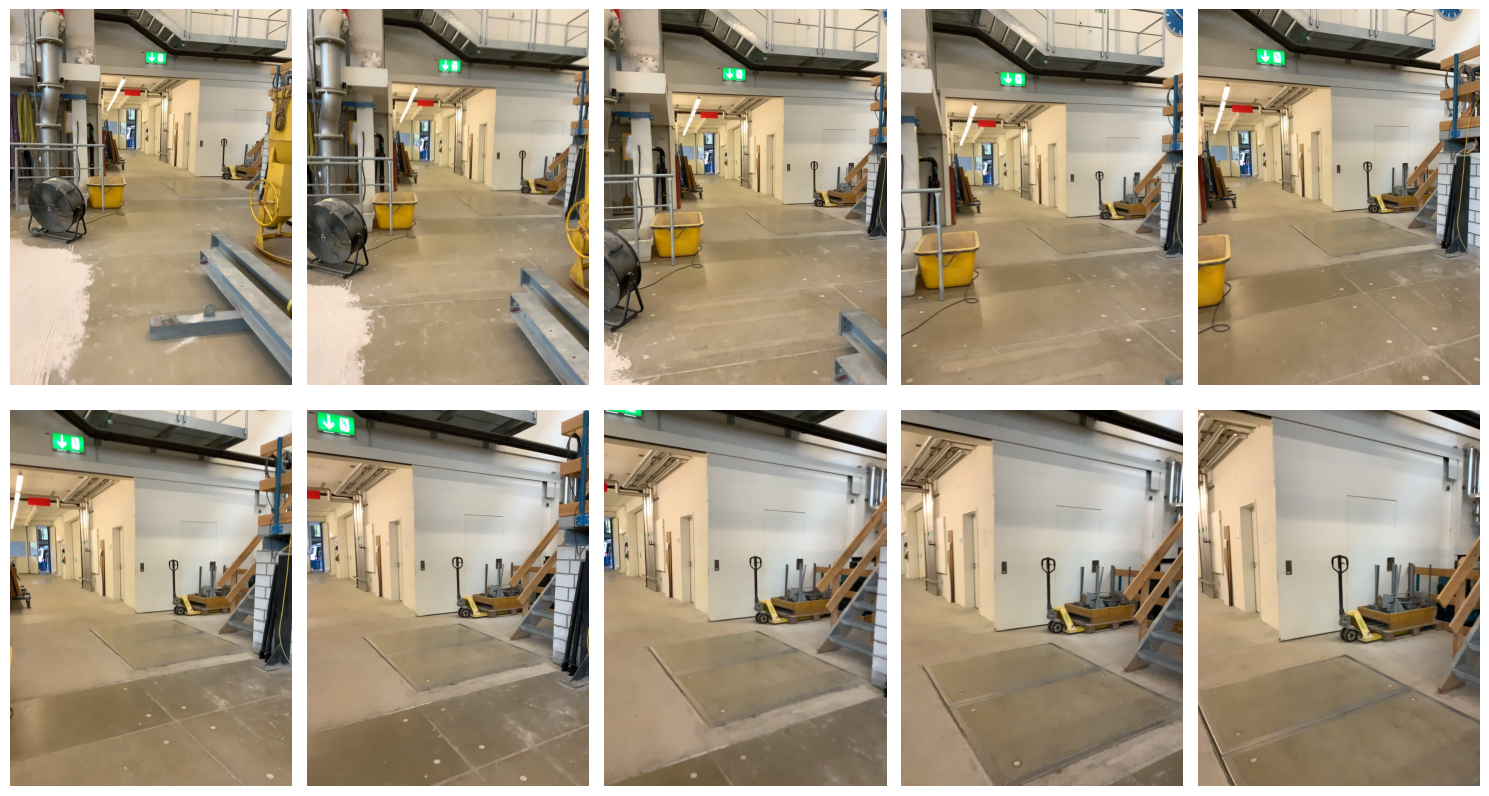

In [3]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 5, figsize=(15, 9))
axs = axs.flatten()
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
for ax, image in zip(axs, images):
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Let's predict first camera pose using all others

In [4]:
actual_poses = np.array([
    data_item['Twc'].numpy()
    for data_item in data
])

In [5]:
from vggt_ba.vggt_ba import ApiInference as Vggt

vggt = Vggt('http://127.0.0.1:8000')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
predictions = vggt.run(paths)
predictions['image_names'] = [
    os.path.basename(path)
    for path in paths
]

Sending data to VGGT. This may take some minutes
Received predictions outputs from VGGT


In [7]:
from vggt_ba.vggt_ba import bundle_adjustment

predictions = bundle_adjustment(predictions)

I20251002 14:39:36.802719 134729623689024 misc.cc:44] 
Global bundle adjustment
I20251002 14:39:43.806312 134729623689024 bundle_adjustment.cc:1174] Bundle adjustment report
    Residuals : 1475782
   Parameters : 2213754
   Iterations : 3
         Time : 6.0645 [s]
 Initial cost : 1.27492e-05 [px]
   Final cost : 4.02148e-14 [px]
  Termination : Convergence

I20251002 14:39:43.806407 134729623689024 timer.cc:91] Elapsed time: 0.117 [minutes]


In [8]:
full_vggt_extrinsics = np.array([np.eye(4) for _ in enumerate(data)])
full_vggt_extrinsics[:, :3, :] = predictions['extrinsic']

full_vggt_extrinsics = np.linalg.inv(full_vggt_extrinsics)

In [9]:
from evo.core.trajectory import PosePath3D
import copy

traj_ref = PosePath3D(poses_se3 = actual_poses[1:])
traj_est = PosePath3D(poses_se3 = full_vggt_extrinsics[1:])

traj_est_aligned = copy.deepcopy(traj_est)

R, t, s = traj_est_aligned.align(traj_ref, correct_scale=True)

In [10]:
def apply_similarity_transform(pose, R, t, s):
    """
    pose: 4x4 numpy array
    R: 3x3 rotation
    t: 3x1 translation
    s: scalar scale
    """
    new_pose = np.eye(4)
    new_pose[:3, :3] = R @ pose[:3, :3]
    new_pose[:3, 3] = s * (R @ pose[:3, 3]) + t
    return new_pose

In [11]:
p0_est = apply_similarity_transform(full_vggt_extrinsics[0], R, t, s)

In [12]:
aligned_vggt_poses = [p0_est] + traj_est_aligned.poses_se3

In [13]:
import random
import open3d as o3d
import numpy as np

def visualize_camera_trajectories(trajectories, scale=0.2):
    """
    trajectories: List of trajectories
                  Each trajectory is a list of 4x4 pose matrices (numpy arrays)
    scale: Size of the coordinate frame (camera model)
    """

    vis_geometries = []

    for i, traj in enumerate(trajectories):
        color = [random.random(), random.random(), random.random()]

        for pose in traj:
            # Create a coordinate frame
            cam = o3d.geometry.TriangleMesh.create_coordinate_frame(size=scale)
            cam.transform(pose)  # Place it using the 4x4 pose
            vis_geometries.append(cam)

        # Optionally connect camera centers with a line
        points = [pose[:3, 3] for pose in traj]
        lines = [[j, j+1] for j in range(len(points)-1)]

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(points)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector([color for _ in lines])

        vis_geometries.append(line_set)

    o3d.visualization.draw_geometries(vis_geometries)


In [14]:
visualize_camera_trajectories([actual_poses,aligned_vggt_poses])

In [15]:
from scipy.spatial.transform import Rotation as R

def compare_poses(T1, T2):
    trans_error = np.linalg.norm(T1[:3, 3] - T2[:3, 3])

    R1 = T1[:3, :3]
    R2 = T2[:3, :3]
    R_diff = R.from_matrix(R1.T @ R2)
    rot_error_deg = R_diff.magnitude() * 180 / np.pi

    return trans_error, rot_error_deg

In [16]:
compare_poses(p0_est, actual_poses[0])

(0.010303390421245692, 2.3940094790292696)